This script investigates the influence of different audio data representations in dimensionality reduction and clustering on a dataset of goose vocalizations.

In [579]:
import glob
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import seaborn as sns
import random
from scipy.signal import resample
from scipy.stats import kurtosis, skew
import parselmouth
from skimage.transform import resize

In [580]:
random.seed(42)

In [581]:
DATAPATH = "/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections"
clip_paths = glob.glob(DATAPATH+"/*.wav")

In [582]:
len(clip_paths)

7590

##### Inspect single call

In [583]:
i = 450
n_fft = 512
hop_overlap = 9
top_db_silence = 40

In [584]:
vocalization, sr = librosa.load(clip_paths[i], sr=None)

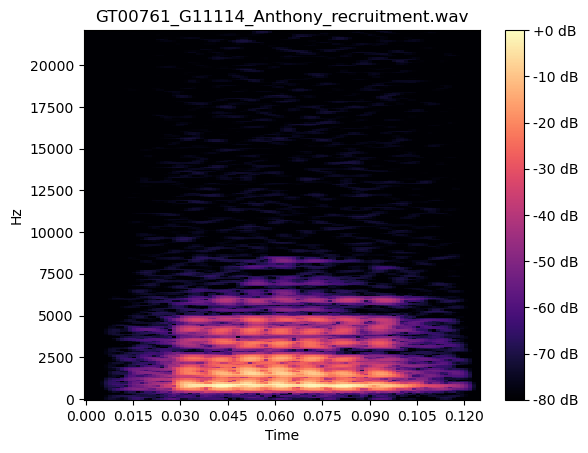

In [585]:
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(vocalization, n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

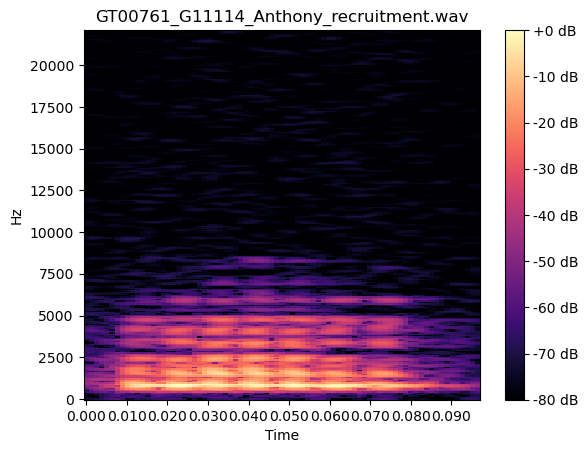

In [586]:
# trim trailing silences using db threshold, discard second entry, that holds indices
fig, ax = plt.subplots()
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(librosa.stft(librosa.effects.trim(vocalization, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0], n_fft=n_fft, hop_length=(n_fft//hop_overlap))), ref=np.max), sr=sr, hop_length=(n_fft//hop_overlap), x_axis='time', y_axis='linear', ax=ax)
ax.set(title=clip_paths[i].split("/")[-1])
fig.colorbar(img, ax=ax, format="%+2.f dB")

min max normalization: 
$X = \frac{X - X_{min}}{X_{max} - X_{min}}$

##### Process clips and write to dataframe
- trim
- normalize 

Read sound files into dataframe and preprocess inside loop:
- Trim silences
- Normalize (peak)

In [587]:
def _min_max_scale(waveform):
    # Normalizes Spectrogram to values between 0 and 1
    return (waveform - waveform.min()) / (waveform.max() - waveform.min())
    
def _peak_normalization(waveform):
    # from biosound package: https://github.com/theunissenlab/BioSoundTutorial/blob/master/BioSound1.ipynb
    return np.array((waveform / np.max(np.abs(waveform))), np.float32)

def _create_spectrogram(spectrogram, plot=False):
    spectrogram = np.abs(librosa.stft(spectrogram, n_fft=n_fft, hop_length=(n_fft//hop_overlap)))
    spectrogram = librosa.amplitude_to_db(spectrogram**2, ref=np.max)
    spectrogram = _min_max_scale(spectrogram) # transform to pixel values
    #spectrogram = spectrogram[::3, ::3] # reduce to a third of the size
    spectrogram = spectrogram[:int(len(spectrogram)*0.7), :] # cut out higher frequencies where no power is left
    if plot:
        fig, ax = plt.subplots()
        ax.matshow(spectrogram, origin="lower", cmap="magma")
        ax.axis("off")
        ax.set(title=clip_paths[i].split("/")[-1])
    return spectrogram

def _process_waveform(waveform):
    trimmed_waveform = librosa.effects.trim(waveform, top_db=top_db_silence, frame_length=n_fft, hop_length=(n_fft//hop_overlap))[0]
    normalized_waveform = _peak_normalization(trimmed_waveform)
    return normalized_waveform

(179, 77)

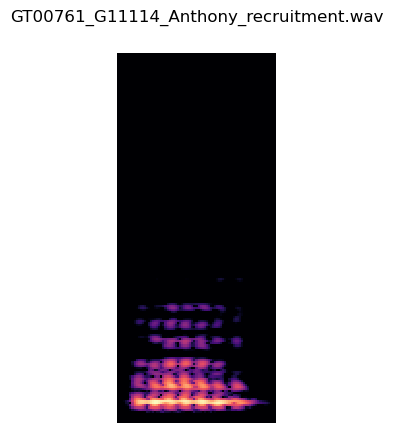

In [588]:
_create_spectrogram(_process_waveform(vocalization), plot=True).shape

In [589]:
calls_df = pd.DataFrame(columns=["track_ID", "clip_ID", "goose_ID", "call_type", "waveform", "sr", "filepath", "spectrogram"])
for clip_path in tqdm(clip_paths):
    waveform, sr = librosa.load(clip_path, sr=None)
    waveform = _process_waveform(waveform) # trim silence and peak normalize
    if np.isnan(waveform).any():
        print(clip_path+" contains na")
        continue
    spectrogram = _create_spectrogram(waveform) # transform to power spectrogram, min-max-scale, cut off higer frequencies
    filename = clip_path.split("/")[-1].split(".")[0]
    calls_df.loc[len(calls_df)] = [filename.split("_")[0], filename.split("_")[1], filename.split("_")[2], filename.split("_")[3], waveform, sr, clip_path, spectrogram]

  9%|▊         | 647/7590 [00:03<00:34, 199.69it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
  9%|▉         | 691/7590 [00:03<00:33, 203.25it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00989_G14229_unknown_alarm.wav contains na


 31%|███       | 2324/7590 [00:11<00:27, 191.64it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 31%|███       | 2371/7590 [00:11<00:25, 203.49it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12616_Kruemmel_unknown.wav contains na


 32%|███▏      | 2417/7590 [00:12<00:25, 201.75it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 32%|███▏      | 2463/7590 [00:12<00:24, 210.54it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)


/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12682_Bregenz_triumph.wav contains na
/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12619_Kruemmel_unknown.wav contains na


 44%|████▍     | 3326/7590 [00:16<00:20, 205.59it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 44%|████▍     | 3368/7590 [00:16<00:21, 197.77it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12633_Kruemmel_unknown.wav contains na


 67%|██████▋   | 5108/7590 [00:25<00:13, 185.51it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 68%|██████▊   | 5147/7590 [00:25<00:13, 187.32it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12622_Kruemmel_unknown.wav contains na


 71%|███████   | 5374/7590 [00:27<00:11, 185.37it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 71%|███████▏  | 5419/7590 [00:27<00:11, 194.37it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12615_Kruemmel_unknown.wav contains na


 76%|███████▌  | 5757/7590 [00:29<00:09, 188.14it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 76%|███████▋  | 5797/7590 [00:29<00:09, 189.05it/s]

/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12631_Kruemmel_unknown.wav contains na


 87%|████████▋ | 6620/7590 [00:33<00:05, 187.10it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)
 87%|████████▋ | 6639/7590 [00:34<00:05, 175.92it/s]/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/3727954012.py:7: RuntimeWarning: invalid value encountered in divide
  return np.array((waveform / np.max(np.abs(waveform))), np.float32)


/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12602_Kruemmel_triumph.wav contains na
/Users/lenagies/Desktop/Master/Thesis/geese/data/clips_from_selections/GT00984_G12763_Bregenz_unknown.wav contains na


100%|██████████| 7590/7590 [00:40<00:00, 189.62it/s]


In [590]:
len(calls_df)

7580

In [591]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram
0,GT00780,G11666,Lando,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,GT00772,G11510,Burglar,recruitment,"[0.0016997167, 0.0056657223, 0.007082153, 0.00...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,GT00795,G11994,EinStein,contact,"[-0.0010507881, -0.0017513135, -0.0017513135, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,GT00447,G04128,BruceSpringsteen,departure,"[-0.00035599858, -0.00071199716, -0.0007119971...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,GT00775,G11567,Anthony,recruitment,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

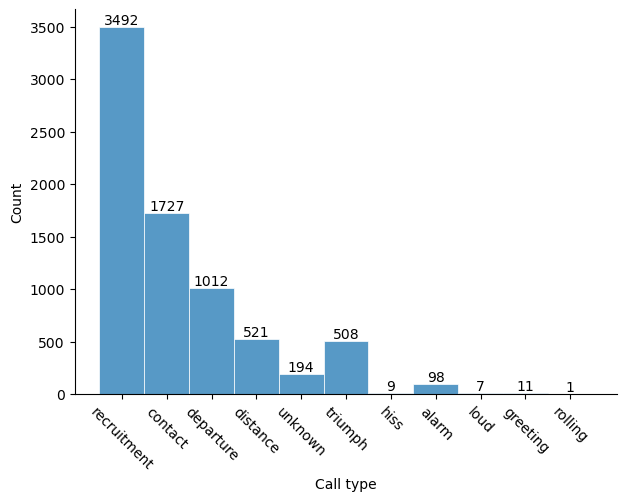

In [592]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

Discard vocalizations labelled as hisses, loud, greeting and rolling calls and only keep random subset of recruitment, departure and contact calls to balance the representations of the different classes. These labels are not used in the current protocol (and we have too few hisses).

In [593]:
# discard loud, greeting and rolling calls
calls_df = calls_df[~calls_df['call_type'].isin(['loud', 'greeting', 'rolling', 'hiss'])]

In [594]:
# only keep random subset of recruitment, departure and contact calls
subset_size = 700

subsample_sizes = {
    'recruitment': subset_size,
    'contact': subset_size,
    'departure': subset_size,
}

# Randomly subsample per call type
def subsample_group(group):
    call_type = group.name  # Group name corresponds to call type
    if call_type in subsample_sizes:
        return group.sample(n=subsample_sizes[call_type], random_state=42)
    return group  # Return untouched if no subsampling is needed

# Group by type and apply subsampling
calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/759216624.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  calls_df = calls_df.groupby('call_type', group_keys=False).apply(subsample_group)


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/1510808998.py:4: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  hist = sns.histplot(


[]

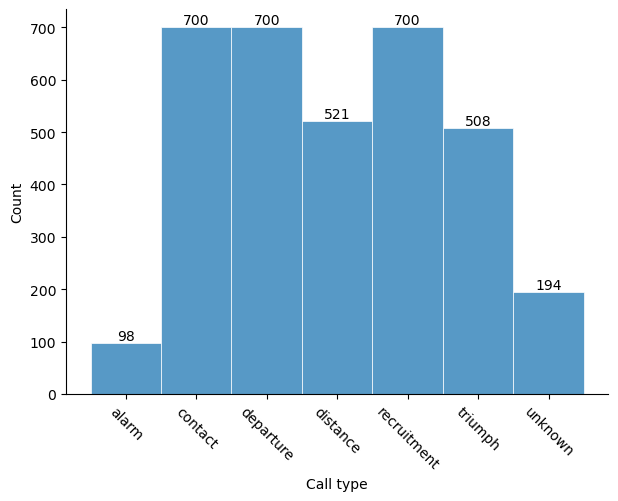

In [595]:
f, ax = plt.subplots(figsize=(7, 5))
sns.despine(f)

hist = sns.histplot(
    calls_df,
    x="call_type",
    multiple="stack",
    palette="viridis",
    edgecolor="1",
    linewidth=.5,
)

plt.xticks(rotation=-45)
ax.set_xlabel("Call type")

# Add counts
for p in hist.patches:
    height = p.get_height()
    x = p.get_x() + p.get_width() / 2
    ax.annotate(f'{int(height)}', (x, height), ha='center', va='bottom')
    
plt.plot()

Plot the durations of the calls

In [596]:
calls_df['duration'] = calls_df.apply(lambda row: len(row['waveform']) / row['sr'], axis=1)
calls_df['log_duration'] = calls_df.apply(lambda row: np.log(row['duration']), axis=1)
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,duration,log_duration
223,GT00052,G00282,Dagobert,alarm,"[-0.0008866558, -0.0008866558, -0.0005172159, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.204444,-1.587459
282,GT00058,G00331,Besenstiel,alarm,"[0.0016202204, 0.0012961762, 0.00032404406, 0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.168889,-1.778514
328,GT00989,G14230,unknown,alarm,"[-0.036363635, 0.07878788, 0.018181818, -0.078...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.4062974, 0.38267127, 0.30062547, 0.1271481...",0.090159,-2.406183
362,GT00055,G00310,Lausbursch,alarm,"[-0.009191881, -0.0099578705, -0.010340866, -0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.341587,-1.074152
719,GT00989,G14235,unknown,alarm,"[-0.001610306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.173968,-1.748882


/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/1401958112.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


([0, 1, 2, 3, 4, 5, 6],
 [Text(0, 0, 'alarm'),
  Text(1, 0, 'contact'),
  Text(2, 0, 'departure'),
  Text(3, 0, 'distance'),
  Text(4, 0, 'recruitment'),
  Text(5, 0, 'triumph'),
  Text(6, 0, 'unknown')])

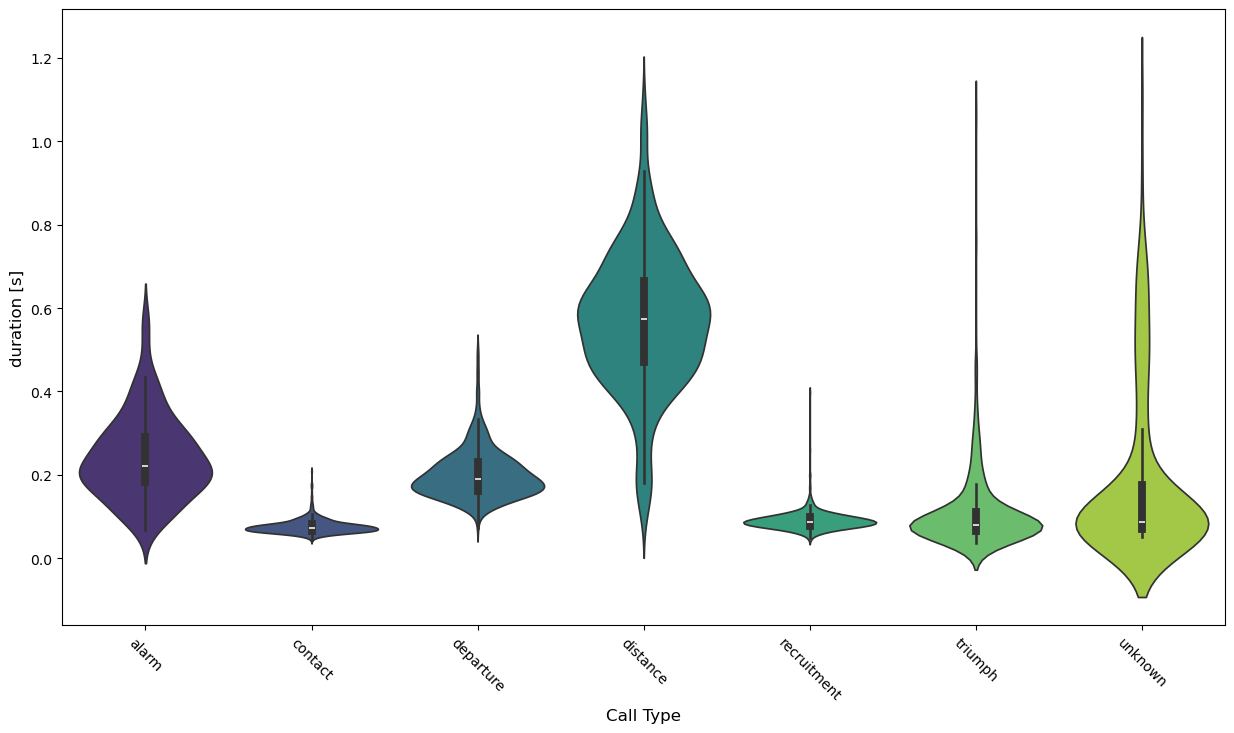

In [597]:
plt.figure(figsize=(15, 8))
sns.violinplot(
    data=calls_df,
    x="call_type",
    y="duration",
    palette="viridis",
    density_norm="width" 
)

plt.xlabel("Call Type", fontsize=12)
plt.ylabel("duration [s]", fontsize=12)
plt.xticks(rotation=-45)

Because the call durations vary substantially, we will log scale the spectrograms before padding to the longest call:

In [598]:
# take the longest call of 99.5th percentile for max length
quantile = np.quantile(calls_df["duration"], 0.997)
filtered_by_percentile = calls_df.loc[calls_df["duration"] >= quantile]
longest_call_quantile = filtered_by_percentile.loc[filtered_by_percentile["duration"].idxmin()]
max_bins = len(longest_call_quantile["spectrogram"][1])

longest_call_total = calls_df.loc[calls_df["duration"].idxmax()]
max_log_duration = longest_call_total["log_duration"]
max_duration_seconds = longest_call_total["duration"]
#max_bins = len(longest_call_total["spectrogram"][1])
shortest_call = calls_df.loc[calls_df["duration"].idxmin()]
min_log_duration = shortest_call["log_duration"]
min_duration_seconds = shortest_call["duration"]

# Compute log scaled target length for the waveform
calls_df["normalized_log_length"] = calls_df.apply(lambda row: (row["log_duration"]-min_log_duration)/(max_log_duration-min_log_duration), axis=1)
calls_df["log_target_duration"] = calls_df.apply(lambda row: row["normalized_log_length"]*(max_duration_seconds-min_duration_seconds)+min_duration_seconds, axis=1)

# sanity check
print(calls_df.loc[calls_df["duration"].idxmin()]["log_target_duration"], min_duration_seconds)
print(calls_df.loc[calls_df["duration"].idxmax()]["log_target_duration"], max_duration_seconds)


# resize spectrogram to match the log scaled target size, reduce to a quarter of the size to avoid too much aliasing when resizing
def _resize_spec(spectrogram, original_duration, target_duration):
    if spectrogram is None or len(spectrogram) == 0:
        print("Empty or None spectrogram")
        return None
    
    if np.isnan(spectrogram).any():
        print("Spectrogram contains NaN values")
        return None

    bin_size_s = original_duration / len(spectrogram[1])
    target_bins_signal = int(target_duration / bin_size_s)

    try:
        # Resample spectrogram to match the target length
        resized_spectrogram = resize(spectrogram, (spectrogram.shape[0] // 4, target_bins_signal // 4), anti_aliasing=False)
        if np.isnan(resized_spectrogram).any():
            print("NaN in resampled spectrogram")
            return None
        
    except Exception as e:
        print(f"Error during resampling: {e}")
        return None
    
    return resized_spectrogram, target_bins_signal
    

# Resample and pad spectrograms, all are downsampled to a quarter of the resolution to avoid aliasing when rescaling to log time and for more effective processing past this point
def rescale_and_pad(spectrogram, original_duration, target_duration, target_bins_total):

    resized_spec, target_bins_signal = _resize_spec(spectrogram, original_duration, target_duration)

    # padding
    total_padding = target_bins_total // 4 - target_bins_signal // 4

    # if above 99th percentile - cut outer bins
    if total_padding < 0:
        return resized_spec[:, :-np.abs(total_padding)] # cut bins on the right because reverb promotes trailing silence in clips

    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    padded_spectrogram = np.pad(resized_spec, [(0, 0), (left_padding, right_padding)], "constant", constant_values=0)
    
    if np.isnan(padded_spectrogram).any():
        print("NaN in padded spectrogram")
        return None
    
    return padded_spectrogram

# Apply transformation to each waveform
calls_df["log_padded_spectrogram"] = calls_df.apply(
    lambda row: rescale_and_pad(
        row["spectrogram"],
        row["duration"],
        row["log_target_duration"],
        max_bins
    ),
    axis=1
)

0.036825396825396824 0.036825396825396824
1.1085714285714285 1.1085714285714285


In [599]:
calls_df[calls_df.isna().any(axis=1)]

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,duration,log_duration,normalized_log_length,log_target_duration,log_padded_spectrogram


In [600]:
calls_df = calls_df.dropna()

Plot log scaled lengths and rescaled length as sanity check before padding

[]

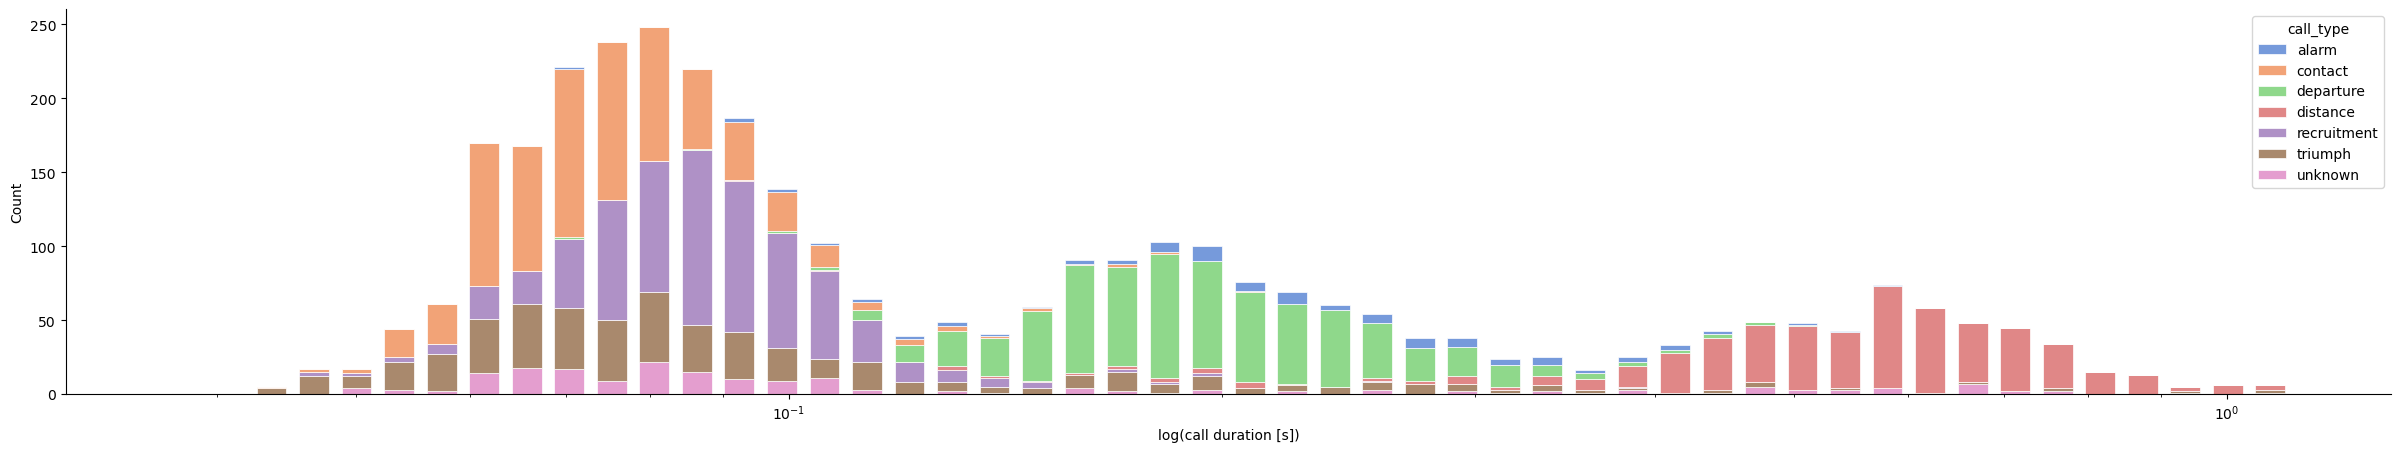

In [601]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

sns.histplot(
    calls_df,
    x="duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    log_scale=True
)
ax.set_xlabel("log(call duration [s])")
plt.plot()

[]

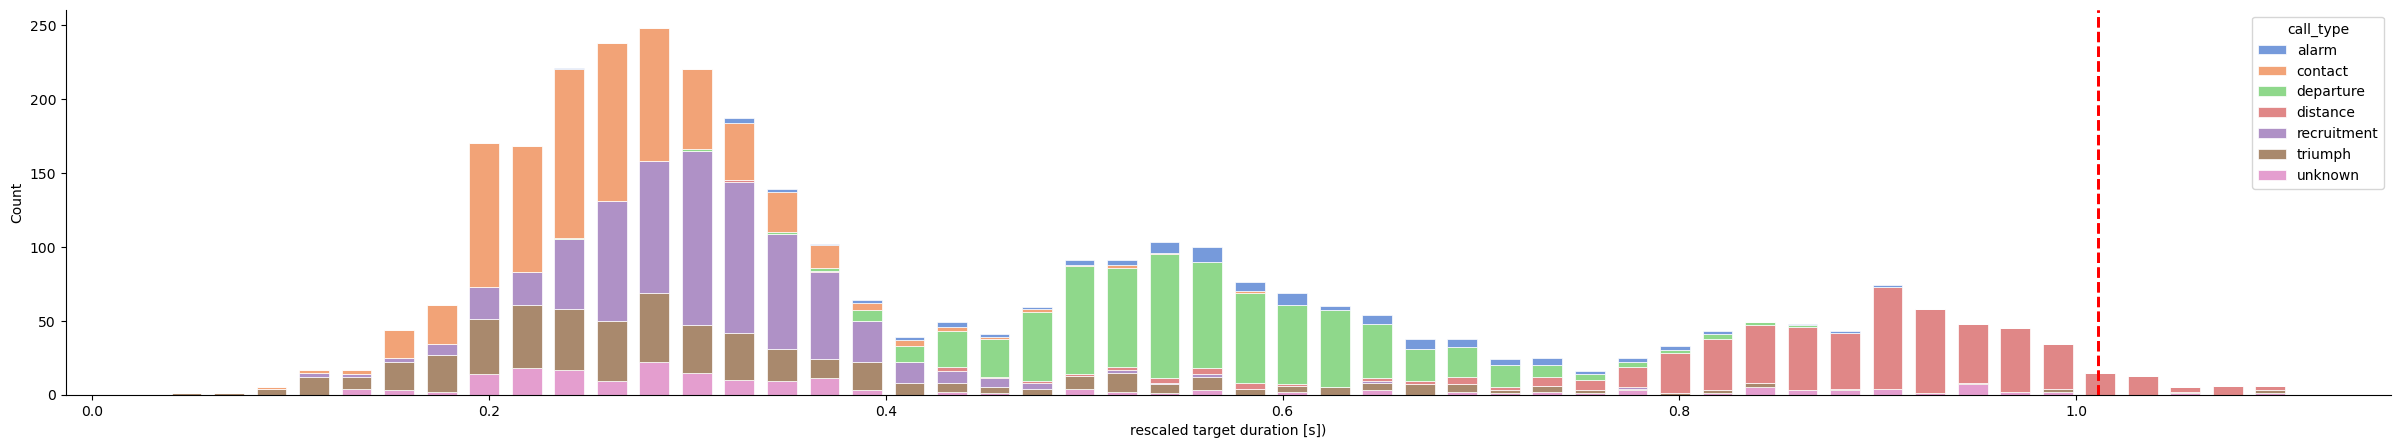

In [602]:
f, ax = plt.subplots(figsize=(30, 5))
sns.despine(f)

histplot = sns.histplot(
    calls_df,
    x="log_target_duration",
    multiple="stack",
    hue="call_type",
    palette="muted",
    edgecolor="1",
    linewidth=.5,
    shrink=.7,
    bins=50,
    ax=ax
)
ax.set_xlabel("rescaled target duration [s])")


quantile = np.quantile(calls_df["duration"], 0.997)
filtered_by_percentile = calls_df.loc[calls_df["duration"] >= quantile]
longest_call_quantile = filtered_by_percentile.loc[filtered_by_percentile["duration"].idxmin()]

ax.axvline(longest_call_quantile["duration"], color='red', linestyle='--', linewidth=2, label=f'99th Percentile: {longest_call_quantile["duration"]:.2f}')

ax.axvline(longest_call_quantile["duration"], color='red', linestyle='--', linewidth=2, label=f'99th Percentile: {longest_call_quantile["log_target_duration"]:.2f}')


plt.plot()

In [603]:
def pad_to_length(spectrogram, target_bins):
    total_padding = target_bins - len(spectrogram[1]) 
    left_padding = total_padding // 2
    right_padding = total_padding - left_padding
    return np.pad(spectrogram, [(0, 0), (left_padding, right_padding)], "constant", constant_values=0)


# Apply transformation to each waveform
calls_df["padded_spectrogram"] = calls_df.apply(
    lambda row: pad_to_length(
        row["spectrogram"],
        len(calls_df.loc[calls_df["duration"].idxmax()]["spectrogram"][1])
    ),
    axis=1
)

In [604]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,duration,log_duration,normalized_log_length,log_target_duration,log_padded_spectrogram,padded_spectrogram
223,GT00052,G00282,Dagobert,alarm,"[-0.0008866558, -0.0008866558, -0.0005172159, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.204444,-1.587459,0.503463,0.576409,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
282,GT00058,G00331,Besenstiel,alarm,"[0.0016202204, 0.0012961762, 0.00032404406, 0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.168889,-1.778514,0.447346,0.516267,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
328,GT00989,G14230,unknown,alarm,"[-0.036363635, 0.07878788, 0.018181818, -0.078...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.4062974, 0.38267127, 0.30062547, 0.1271481...",0.090159,-2.406183,0.262989,0.318683,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
362,GT00055,G00310,Lausbursch,alarm,"[-0.009191881, -0.0099578705, -0.010340866, -0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.341587,-1.074152,0.654229,0.737993,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
719,GT00989,G14235,unknown,alarm,"[-0.001610306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.173968,-1.748882,0.456050,0.525595,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


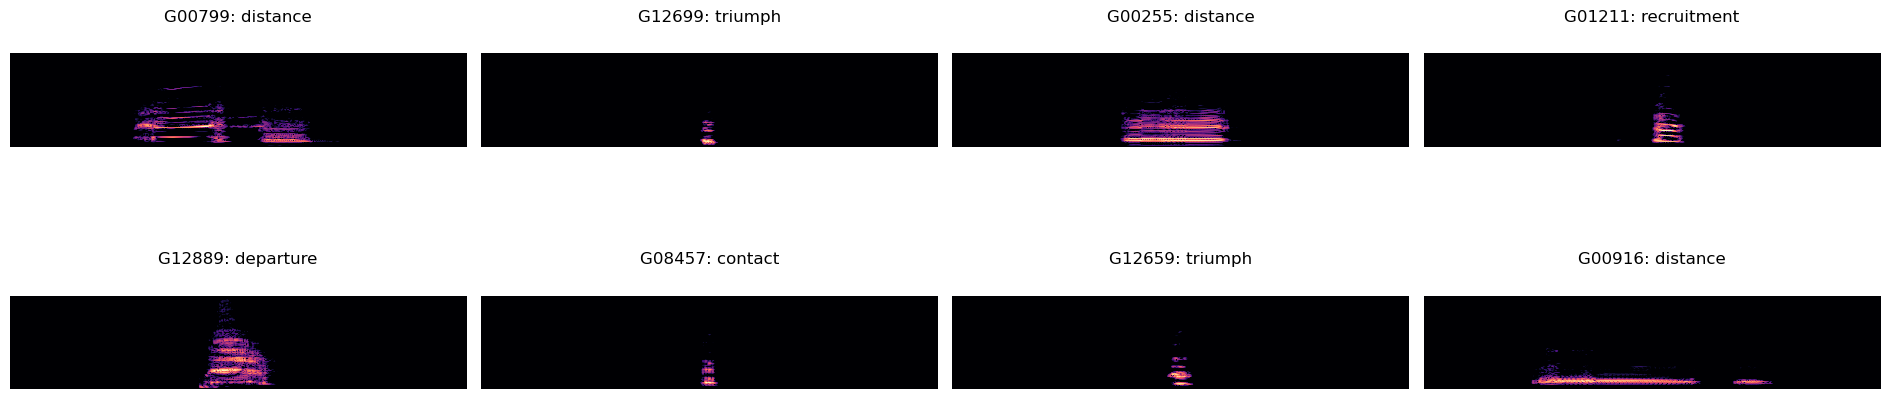

In [605]:
# plot random sample of 8 calls
sample_calls = calls_df.sample(n=8, random_state=43)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
    row = i // 4
    col = i % 4
    axes[row, col].matshow(vocalization["padded_spectrogram"], origin="lower", cmap="magma")
    axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
    axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

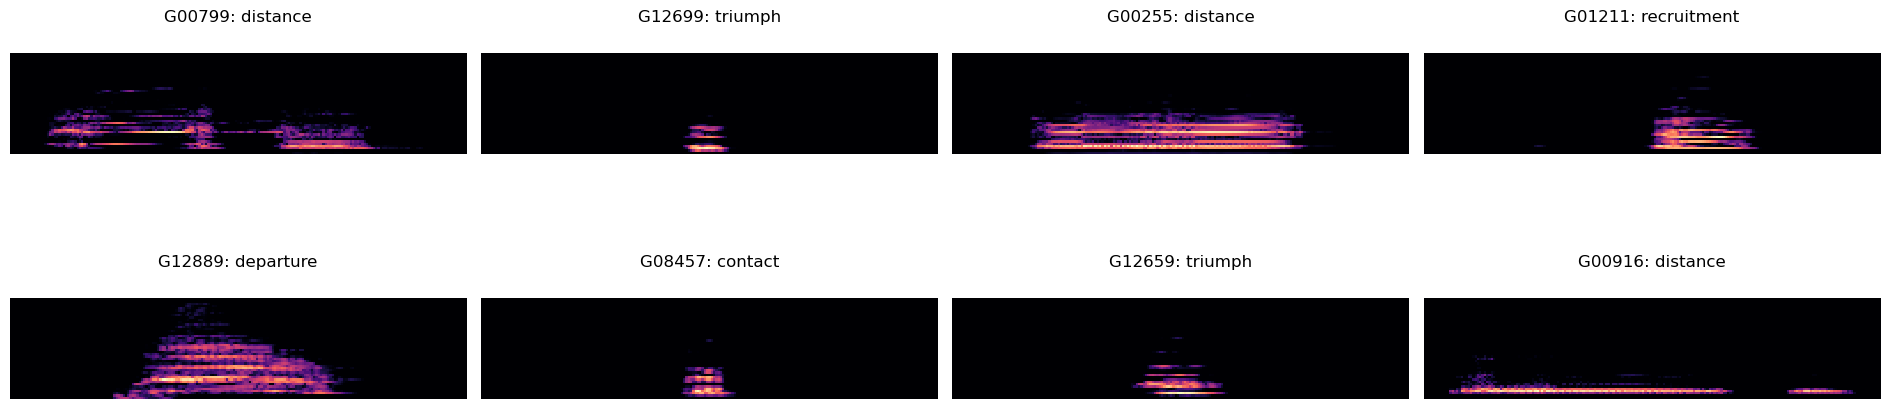

In [606]:
# plot random sample of 8 calls
sample_calls = calls_df.sample(n=8, random_state=43)

# plot first 8 calls
#sample_calls = calls_df.iloc[:8]

fig, axes = plt.subplots(2, 4, figsize=(19, 6))

for i, (_, vocalization) in enumerate(sample_calls.iterrows()):
    row = i // 4
    col = i % 4
    axes[row, col].matshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
    axes[row, col].set_title(f'{vocalization["clip_ID"]}: {vocalization["call_type"]}', )
    axes[row, col].axis("off") 
    
for i in range(len(sample_calls), 8):
  row = i // 4
  col = i % 4
  axes[row, col].axis("off")

plt.tight_layout()
plt.show()

[Text(0.5, 1.0, 'GT00727_G10278_Disney_recruitment.wav')]

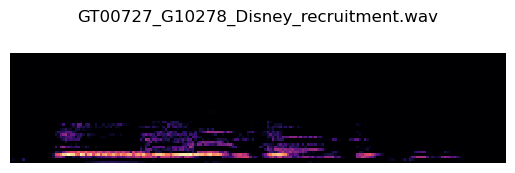

In [607]:
fig, ax = plt.subplots()
longest_call_total = calls_df.loc[calls_df["duration"].idxmax()]
ax.matshow(longest_call_total["log_padded_spectrogram"], origin="lower", cmap="magma")
ax.axis("off")
ax.set(title=clip_paths[i].split("/")[-1])

##### Extract audio features using **Praat/Parselmouth**: 


**Temporal features (retrieved from temporal envelope in amlitude pressure):**
- Mean T: temporal centroid
- Std T: temporal duration
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
- Ent T: temporal entropy (overall variability)

**Spectral features (from spectral envelope in power/pressure square):**
- Mean S: spectral centroid
- Std S: spectral duration
- Skew S: spectral skewness (asymmery)
- Kurt S: spectral kurtosis (peakedness)
- Ent S: spectral entropy (overall variability)
- Q1, Q2, G3: q-th quartile of power spectrum

**From time-varying fundamental frequency:**
- Mean F0: mean fundamental frequency
- Sal: mean pitch saliency (ratio)
- Max F0: mean fundamental
- Min F0: minimum fundamental
- CV F0: coefficient of variation (measure of frequency modulation)

In [608]:
f0_floor = 350
f0_ceil = 2000
vtl_m = 0.378 # Würdinger 1970, taken from Anser fabilis, because most similar overall body size to Anser anser

In [609]:
def plot_spectrogram(snd, pitch=None, intensity=None, formants=None, dynamic_range=70):
    spectrogram = snd.to_spectrogram(window_length=0.01, maximum_frequency=10000, time_step=0.0005, window_shape=parselmouth.SpectralAnalysisWindowShape.HANNING)

    X, Y = spectrogram.x_grid(), spectrogram.y_grid()
    sg_db = 10 * np.log10(spectrogram.values)
    plt.pcolormesh(X, Y, sg_db, vmin=sg_db.max() - dynamic_range, cmap='afmhot')
    plt.ylim([spectrogram.ymin, spectrogram.ymax])
    plt.xlabel("time [s]")
    plt.ylabel("frequency [Hz]")

    if pitch:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_pitch(pitch, ylim=[spectrogram.ymin, spectrogram.ymax])
    
    if formants:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_formants(formants, snd.xmin, snd.xmax, ylim=[spectrogram.ymin, spectrogram.ymax])
    
    plt.show()

    if intensity:
        plt.twinx()
        plt.xlim([snd.xmin, snd.xmax])
        _plot_intensity(intensity)
    
    plt.show()

    
def _plot_pitch(pitch, ylim=[]):
    pitch_values = pitch.selected_array['frequency']
    pitch_values[pitch_values==0] = np.nan
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=5, color='w')
    plt.plot(pitch.xs(), pitch_values, 'o', markersize=2)
    plt.grid(False)
    if ylim==[]:
        plt.ylim(0, pitch.ceiling)
    else: 
        plt.ylim(ylim)
    plt.ylabel("fundamental frequency [Hz]")

def _plot_intensity(intensity):
    intensity_values = intensity.values[0]
    intensity_values[intensity_values==0] = np.nan
    plt.plot(intensity.xs(), intensity_values, 'o', markersize=2)
    plt.grid(False)
    plt.ylim(0, np.max(intensity_values))
    plt.ylabel("intensity [dB SPL]")

def _plot_formants(formants, xmin, xmax, ylim=[]):
    plt.plot(np.linspace(xmin, xmax, len(formants[0])), formants[0], 'o', markersize=2)
    plt.plot(np.linspace(xmin, xmax, len(formants[1])), formants[1], 'o', markersize=2)
    plt.plot(np.linspace(xmin, xmax, len(formants[2])), formants[2], 'o', markersize=2)
    plt.plot(np.linspace(xmin, xmax, len(formants[3])), formants[3], 'o', markersize=2)
    plt.grid(False)
    if ylim==[]:
        plt.ylim(0, np.max(formants))
    else:
        plt.ylim(ylim)

In [610]:
# fundamental
"""
- ~~ Mean F0: mean fundamental frequency
- ~~ Sal: mean pitch saliency (ratio) - hnr instead
- ~~ Max F0: maximum fundamental
- ~~ Min F0: minimum fundamental
- ~~ CV F0: coefficient of variation (measure of frequency modulation) -std instead
"""
def calculate_f0_related_features(snd, f0_floor, f0_ceil):
    # https://parselmouth.readthedocs.io/en/stable/api_reference.html#parselmouth.Sound.to_pitch
    pitch = parselmouth.praat.call(snd, "To Pitch", 0, f0_floor, f0_ceil)
    f0mean = parselmouth.praat.call(pitch, "Get mean", 0, 0, "Hertz")
    f0min = parselmouth.praat.call(pitch, "Get minimum", 0, 0, "Hertz", "parabolic")
    f0max = parselmouth.praat.call(pitch, "Get maximum", 0, 0, "Hertz", "parabolic")
    f0range = f0max - f0min
    f0stdDev = parselmouth.praat.call(pitch, "Get standard deviation", 0, 0, "Hertz")
    mean_slope = pitch.get_mean_absolute_slope()
    f0_q1 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.25, "Hertz")
    f0_q2 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.5, "Hertz")
    f0_q3 = parselmouth.praat.call(pitch, "Get quantile", 0.0, 0.0, 0.75, "Hertz")
    return f0mean, f0min, f0max, f0range, f0stdDev, mean_slope, pitch, f0_q1, f0_q2, f0_q3

# spectral
def calculate_hnr(snd):
    harmonicity = snd.to_harmonicity()
    return harmonicity.values[harmonicity.values != -200].mean()

def calculate_spectral_features(snd):
    spectrum = snd.to_spectrum()
    centr_s = spectrum.get_center_of_gravity()
    skew_s = spectrum.get_skewness()
    kurt_s = spectrum.get_kurtosis()
    std_s = spectrum.get_standard_deviation()
    #entropy
    #quantiles
    return centr_s, skew_s, kurt_s, std_s
"""
- -- Mean S: spectral centroid
- Std S: spectral duration
- -- Skew S: spectral skewness (asymmery)
- -- Kurt S: spectral kurtosis (peakedness)
- ~~ Ent S: spectral entropy (overall variability) - std instead
- -- Q1, Q2, Q3: q-th quartile of power spectrum
"""

# temporal
def calculate_temporal_features(snd):
    intensity = snd.to_intensity(minimum_pitch=350)
    centr_t = intensity.centre_time
    std_t = np.std(intensity.values[0])
    skew_t = skew(intensity.values[0])
    kurt_t = kurtosis(intensity.values[0])
    return centr_t, skew_t, kurt_t, std_t, intensity

"""
- Cent T: temporal centroid
- Std T: temporal std
- Skew T: temporal skewness (asymmery)
- Kurt T: temporal kurtosis (peakedness)
"""

# formants
def _estimate_formant_ceiling(vtl_m):
    return 19*(340/(4*vtl_m))*1.1 # lower formants are expected to be below f0

def calculate_formants(snd):
    # from https://github.com/drfeinberg/PraatScripts/blob/master/Measure%20Pitch%2C%20HNR%2C%20Jitter%2C%20Shimmer%2C%20and%20Formants.ipynb
    formant_ceiling = _estimate_formant_ceiling(vtl_m)
    pointProcess = parselmouth.praat.call(snd, "To PointProcess (periodic, cc)", f0_floor, f0_ceil)
    formants = parselmouth.praat.call(snd, "To Formant (burg)", 0.0, 4, formant_ceiling, formant_ceiling*0.000005, 20)
    numPoints = parselmouth.praat.call(pointProcess, "Get number of points")

    f1_list = []
    f2_list = []
    f3_list = []
    f4_list = []
    
    # Measure formants only at glottal pulses
    for point in range(0, numPoints):
        point += 1
        t = parselmouth.praat.call(pointProcess, "Get time from index", point)
        f1 = parselmouth.praat.call(formants, "Get value at time", 1, t, 'Hertz', 'Linear')
        f2 = parselmouth.praat.call(formants, "Get value at time", 2, t, 'Hertz', 'Linear')
        f3 = parselmouth.praat.call(formants, "Get value at time", 3, t, 'Hertz', 'Linear')
        f4 = parselmouth.praat.call(formants, "Get value at time", 4, t, 'Hertz', 'Linear')
        f1_list.append(f1)
        f2_list.append(f2)
        f3_list.append(f3)
        f4_list.append(f4)
    
    f1_list = [f1 for f1 in f1_list if str(f1) != 'nan']
    f2_list = [f2 for f2 in f2_list if str(f2) != 'nan']
    f3_list = [f3 for f3 in f3_list if str(f3) != 'nan']
    f4_list = [f4 for f4 in f4_list if str(f4) != 'nan']
    
    # calculate mean formants across pulses
    f1_mean = np.mean(f1_list)
    f2_mean = np.mean(f2_list)
    f3_mean = np.mean(f3_list)
    f4_mean = np.mean(f4_list)

    return [f1_mean, f2_mean, f3_mean, f4_mean], [f1_list, f2_list, f3_list, f4_list]


In [611]:
def calc_features(filepath, plot_spectrogram=False):
    snd = parselmouth.Sound(filepath)
    f0mean, f0range, f0min, f0max, f0std_dev, mean_slope, pitch, f0_q1, f0_q2, f0_q3 = calculate_f0_related_features(snd, f0_floor, f0_ceil)
    hnr = calculate_hnr(snd)
    # spectral
    centr_s, skew_s, kurt_s, std_s = calculate_spectral_features(snd)
    # temporal
    centr_t, skew_t, kurt_t, std_t, intensity = calculate_temporal_features(snd)
    # formants
    formants, formant_lists = calculate_formants(snd)
    if plot_spectrogram:
        plot_spectrogram(snd, pitch, intensity, formant_lists)
    return pd.DataFrame([[filepath, f0mean, f0range, f0min, f0max, f0std_dev, mean_slope, f0_q1, f0_q2, f0_q3, hnr, centr_s, skew_s, kurt_s, std_s, centr_t, skew_t, kurt_t, std_t, formants[0], formants[1], formants[2], formants[3]]], columns = ["filepath", "f0mean", "f0range", "f0min", "f0max", "f0std_dev", "mean_slope", "f0_q1", "f0_q2", "f0_q3", "hnr", "centr_s", "skew_s", "kurt_s", "std_s", "centr_t", "skew_t", "kurt_t", "std_t", "avg_f_form1", "avg_f_form2" , "avg_f_form3", "avg_f_form4"])

In [612]:
features_df = calc_features(calls_df.iloc[1260]["filepath"])
features_df.head()

,filepath,f0mean,f0range,f0min,f0max,f0std_dev,mean_slope,f0_q1,f0_q2,f0_q3,...,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1,avg_f_form2,avg_f_form3,avg_f_form4
0,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1107.069218,1037.419548,1216.242463,178.822916,40.505552,11946.854946,1075.571795,1109.298332,1129.002306,...,10.929069,795.165781,0.064456,-1.211622,0.341312,7.737139,1079.842675,2237.23601,3118.657493,4149.677423


In [613]:
features_df = pd.DataFrame()

for _, row in calls_df.iterrows():
    temp_df = calc_features(row["filepath"])
    features_df = pd.concat([features_df, temp_df], ignore_index=True)

features_df.head()

/var/folders/kl/qgqbw3bd42bf_tybhvnz9vxh0000gn/T/ipykernel_97203/1957060190.py:26: RuntimeWarning: Mean of empty slice.
  return harmonicity.values[harmonicity.values != -200].mean()
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/Users/lenagies/anaconda3/envs/goose_vocalizations/lib/python3.11/site-packages/numpy/_core/fromnumeric.py:3596: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,


,filepath,f0mean,f0range,f0min,f0max,f0std_dev,mean_slope,f0_q1,f0_q2,f0_q3,...,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1,avg_f_form2,avg_f_form3,avg_f_form4
0,/Users/lenagies/Desktop/Master/Thesis/geese/da...,877.138325,825.896144,925.840528,99.944384,22.669908,3477.968862,860.345698,877.126020,894.283432,...,5.521327,1862.916438,0.231474,-2.700455,6.538478,92.549320,1616.990397,2197.148523,3478.998642,3952.066913
1,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1024.114457,679.049235,1205.398864,526.349628,163.861712,13272.653401,891.900452,1083.187893,1124.979818,...,2.561363,816.904709,0.156644,-0.330461,-1.219547,26.480288,1059.670466,2020.352716,2738.944888,3628.634564
2,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1005.858048,861.913756,1269.198003,407.284248,141.956447,13418.157276,902.223989,930.858223,1162.142947,...,0.643740,2117.794840,0.073628,-0.929844,-1.078069,142.261274,1558.894383,2078.538642,3546.275987,3739.976424
3,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1163.502602,937.714364,1281.607130,343.892766,77.205086,23983.048842,1096.354655,1174.012665,1232.246675,...,12.943833,482.630433,0.233220,0.721941,-0.947202,16.135153,1122.136070,1654.332442,2548.684413,3764.864210
4,/Users/lenagies/Desktop/Master/Thesis/geese/da...,1318.373756,1231.775633,1434.196828,202.421196,42.312494,6882.774653,1292.476030,1307.020302,1347.439894,...,195.954688,396.684880,0.136644,-3.341352,10.546476,77.254176,1250.963230,1528.429774,2686.957678,3987.910141


In [614]:
calls_df = pd.merge(calls_df, features_df, how='left', on='filepath')

In [615]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,duration,log_duration,...,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1,avg_f_form2,avg_f_form3,avg_f_form4
0,GT00052,G00282,Dagobert,alarm,"[-0.0008866558, -0.0008866558, -0.0005172159, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.204444,-1.587459,...,5.521327,1862.916438,0.231474,-2.700455,6.538478,92.549320,1616.990397,2197.148523,3478.998642,3952.066913
1,GT00058,G00331,Besenstiel,alarm,"[0.0016202204, 0.0012961762, 0.00032404406, 0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.168889,-1.778514,...,2.561363,816.904709,0.156644,-0.330461,-1.219547,26.480288,1059.670466,2020.352716,2738.944888,3628.634564
2,GT00989,G14230,unknown,alarm,"[-0.036363635, 0.07878788, 0.018181818, -0.078...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.4062974, 0.38267127, 0.30062547, 0.1271481...",0.090159,-2.406183,...,0.643740,2117.794840,0.073628,-0.929844,-1.078069,142.261274,1558.894383,2078.538642,3546.275987,3739.976424
3,GT00055,G00310,Lausbursch,alarm,"[-0.009191881, -0.0099578705, -0.010340866, -0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.341587,-1.074152,...,12.943833,482.630433,0.233220,0.721941,-0.947202,16.135153,1122.136070,1654.332442,2548.684413,3764.864210
4,GT00989,G14235,unknown,alarm,"[-0.001610306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.173968,-1.748882,...,195.954688,396.684880,0.136644,-3.341352,10.546476,77.254176,1250.963230,1528.429774,2686.957678,3987.910141


##### Analyze acoustic features

In [616]:
import umap
from umap.umap_ import nearest_neighbors
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Patch

from mpl_toolkits.mplot3d import Axes3D

In [617]:
calls_df.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,duration,log_duration,...,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1,avg_f_form2,avg_f_form3,avg_f_form4
0,GT00052,G00282,Dagobert,alarm,"[-0.0008866558, -0.0008866558, -0.0005172159, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.204444,-1.587459,...,5.521327,1862.916438,0.231474,-2.700455,6.538478,92.549320,1616.990397,2197.148523,3478.998642,3952.066913
1,GT00058,G00331,Besenstiel,alarm,"[0.0016202204, 0.0012961762, 0.00032404406, 0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.168889,-1.778514,...,2.561363,816.904709,0.156644,-0.330461,-1.219547,26.480288,1059.670466,2020.352716,2738.944888,3628.634564
2,GT00989,G14230,unknown,alarm,"[-0.036363635, 0.07878788, 0.018181818, -0.078...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.4062974, 0.38267127, 0.30062547, 0.1271481...",0.090159,-2.406183,...,0.643740,2117.794840,0.073628,-0.929844,-1.078069,142.261274,1558.894383,2078.538642,3546.275987,3739.976424
3,GT00055,G00310,Lausbursch,alarm,"[-0.009191881, -0.0099578705, -0.010340866, -0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.341587,-1.074152,...,12.943833,482.630433,0.233220,0.721941,-0.947202,16.135153,1122.136070,1654.332442,2548.684413,3764.864210
4,GT00989,G14235,unknown,alarm,"[-0.001610306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.173968,-1.748882,...,195.954688,396.684880,0.136644,-3.341352,10.546476,77.254176,1250.963230,1528.429774,2686.957678,3987.910141


In [630]:
len(calls_df[calls_df.isna().any(axis=1)])
data_cleaned = calls_df.dropna()

In [631]:
data_cleaned.head()

,track_ID,clip_ID,goose_ID,call_type,waveform,sr,filepath,spectrogram,duration,log_duration,...,kurt_s,std_s,centr_t,skew_t,kurt_t,std_t,avg_f_form1,avg_f_form2,avg_f_form3,avg_f_form4
0,GT00052,G00282,Dagobert,alarm,"[-0.0008866558, -0.0008866558, -0.0005172159, ...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.204444,-1.587459,...,5.521327,1862.916438,0.231474,-2.700455,6.538478,92.549320,1616.990397,2197.148523,3478.998642,3952.066913
1,GT00058,G00331,Besenstiel,alarm,"[0.0016202204, 0.0012961762, 0.00032404406, 0....",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.168889,-1.778514,...,2.561363,816.904709,0.156644,-0.330461,-1.219547,26.480288,1059.670466,2020.352716,2738.944888,3628.634564
2,GT00989,G14230,unknown,alarm,"[-0.036363635, 0.07878788, 0.018181818, -0.078...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.4062974, 0.38267127, 0.30062547, 0.1271481...",0.090159,-2.406183,...,0.643740,2117.794840,0.073628,-0.929844,-1.078069,142.261274,1558.894383,2078.538642,3546.275987,3739.976424
3,GT00055,G00310,Lausbursch,alarm,"[-0.009191881, -0.0099578705, -0.010340866, -0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.341587,-1.074152,...,12.943833,482.630433,0.233220,0.721941,-0.947202,16.135153,1122.136070,1654.332442,2548.684413,3764.864210
4,GT00989,G14235,unknown,alarm,"[-0.001610306, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0...",44100,/Users/lenagies/Desktop/Master/Thesis/geese/da...,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.173968,-1.748882,...,195.954688,396.684880,0.136644,-3.341352,10.546476,77.254176,1250.963230,1528.429774,2686.957678,3987.910141


In [632]:
n_neighbors = 15

In [633]:
features_scaled = StandardScaler().fit_transform(data_cleaned.drop(columns=["call_type", "track_ID", "clip_ID", "goose_ID", "waveform", "sr", "filepath", "log_duration", "normalized_log_length", "log_target_duration", "log_padded_spectrogram", "padded_spectrogram", "spectrogram"]))
# considering scaling: https://github.com/lmcinnes/umap/issues/66

In [634]:
nn_results_paf = nearest_neighbors(
    features_scaled,
    n_neighbors = n_neighbors,
    metric = "euclidean",
    metric_kwds = {},
    angular=False,
    random_state = 42,
    verbose=True,
)

Fri Dec  6 14:38:04 2024 Finding Nearest Neighbors
Fri Dec  6 14:38:04 2024 Building RP forest with 8 trees
Fri Dec  6 14:38:04 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	Stopping threshold met -- exiting after 3 iterations
Fri Dec  6 14:38:04 2024 Finished Nearest Neighbor Search


In [637]:
def display_nearest_neighbours(nn_graph, df, n_examples=5, n_neighbors=15):
    fig, axs = plt.subplots(nrows=n_examples, ncols=n_neighbors, figsize=(n_neighbors, n_examples))

    for i in range(n_examples):
        for j in range(n_neighbors):
            axs[i, j].matshow(df.iloc[nn_graph[0][i][j]]["log_padded_spectrogram"], origin="lower", cmap="magma", aspect="auto")
            axs[i, j].axis("off")
    plt.tight_layout()
    plt.show()

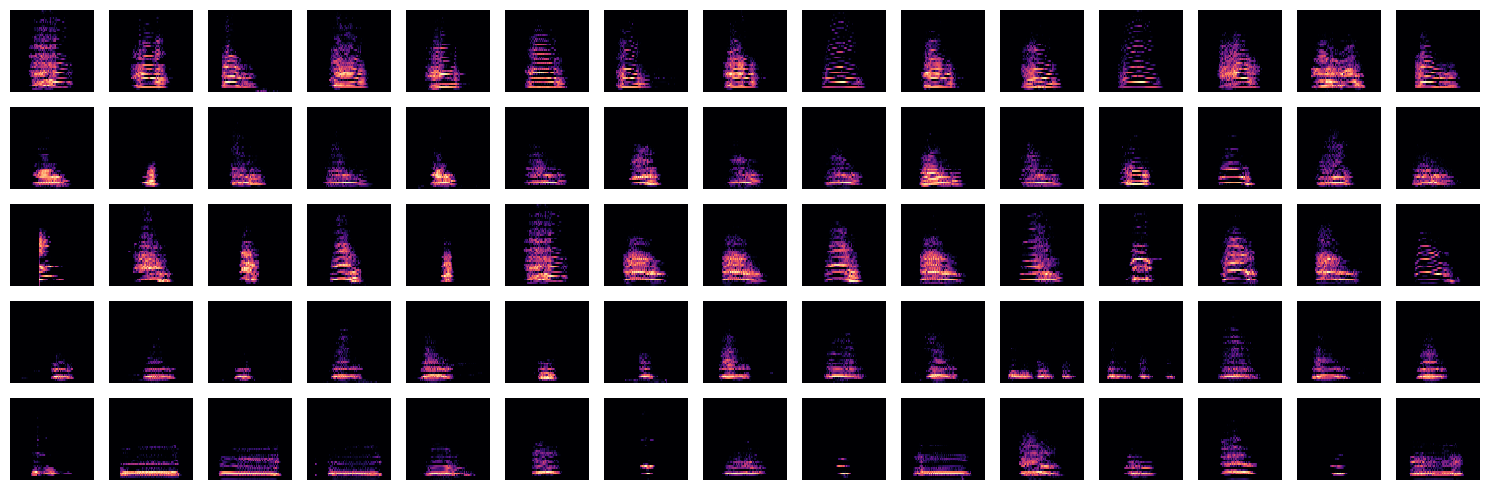

In [638]:
display_nearest_neighbours(nn_results_paf, data_cleaned)

In [639]:
embeddings = umap.UMAP(precomputed_knn=nn_results_paf, n_neighbors=15, n_components=2, min_dist=0.1).fit_transform(features_scaled)

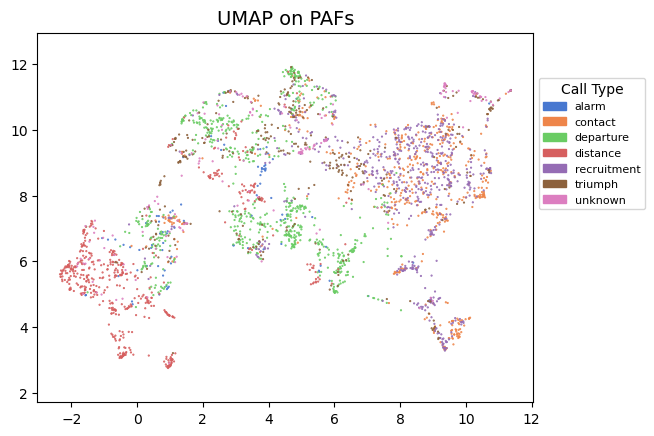

In [640]:
unique_call_types = data_cleaned["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_call_types))
call_type_to_color = {call_type: color for call_type, color in zip(unique_call_types, color_palette)}

# Assign colors to points
colors = [call_type_to_color[call_type] for call_type in data_cleaned["call_type"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on PAFs', fontsize=14)

# Legend
legend_patches = [Patch(color=color, label=call_type) for call_type, color in call_type_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)

plt.show()

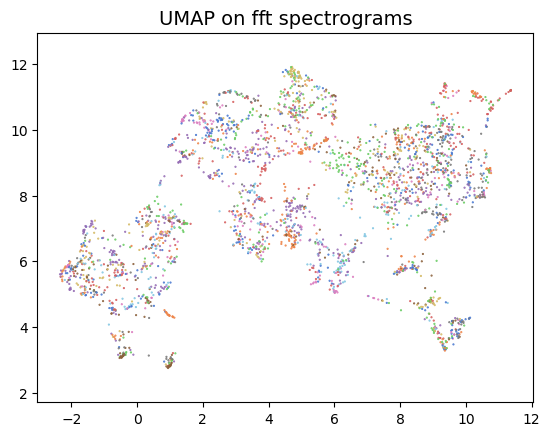

In [641]:
unique_goose_ids = data_cleaned["goose_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {goose_id: color for goose_id, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[goose_id] for goose_id in data_cleaned["goose_ID"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
# legend_patches = [Patch(color=color, label=goose_id) for goose_id, color in goose_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Goose ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

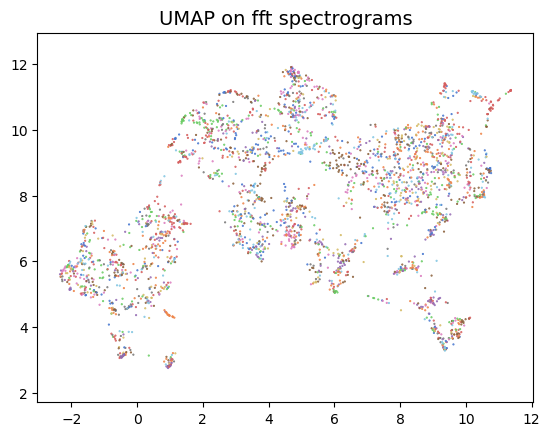

In [642]:
unique_track_ids = data_cleaned["track_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_track_ids))
goose_id_to_color = {track_id: color for track_id, color in zip(unique_track_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[track_id] for track_id in data_cleaned["track_ID"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

plt.show()

##### Analyze spectrograms

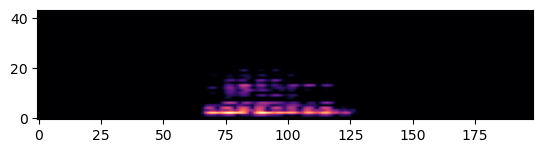

(179, 78)


In [685]:
# longest call
#vocalization = calls_df.loc[calls_df["duration"].idxmax()]
# random call
vocalization = calls_df.iloc()[np.random.randint(0, len(calls_df))]

plt.imshow(vocalization["log_padded_spectrogram"], origin="lower", cmap="magma")
plt.show()
print(vocalization["spectrogram"].shape)

In [688]:
labels_and_spectrograms = []
for idx, row in calls_df.iterrows():
    labels_and_spectrograms.append([row["call_type"], row["track_ID"], row["goose_ID"], *row["log_padded_spectrogram"].flatten()])

In [690]:
column_names = ["call_type", "track_ID", "goose_ID"]
for i in range(len(calls_df.iloc[0]["log_padded_spectrogram"].flatten())):
    column_names.append(i)

In [691]:
labels_and_spectrograms_df = pd.DataFrame(labels_and_spectrograms, columns=column_names, index=None) 

In [692]:
labels_and_spectrograms_df.head()

,call_type,track_ID,goose_ID,0,1,2,3,4,5,6,...,8746,8747,8748,8749,8750,8751,8752,8753,8754,8755
0,alarm,GT00052,Dagobert,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,alarm,GT00058,Besenstiel,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,alarm,GT00989,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,alarm,GT00055,Lausbursch,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,alarm,GT00989,unknown,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


##### UMAP

In [693]:
labels_and_spectrograms_scaled = StandardScaler().fit_transform(labels_and_spectrograms_df.drop(columns=["call_type", "track_ID", "goose_ID"]))

In [694]:
nn_results_spec = nearest_neighbors(
    labels_and_spectrograms_scaled,
    n_neighbors = n_neighbors,
    metric = "euclidean",
    metric_kwds = {},
    angular=False,
    random_state = 42,
    verbose=True,
)

Fri Dec  6 15:12:58 2024 Finding Nearest Neighbors
Fri Dec  6 15:12:59 2024 Building RP forest with 8 trees
Fri Dec  6 15:12:59 2024 NN descent for 12 iterations
	 1  /  12
	 2  /  12
	 3  /  12
	 4  /  12
	Stopping threshold met -- exiting after 4 iterations
Fri Dec  6 15:13:00 2024 Finished Nearest Neighbor Search


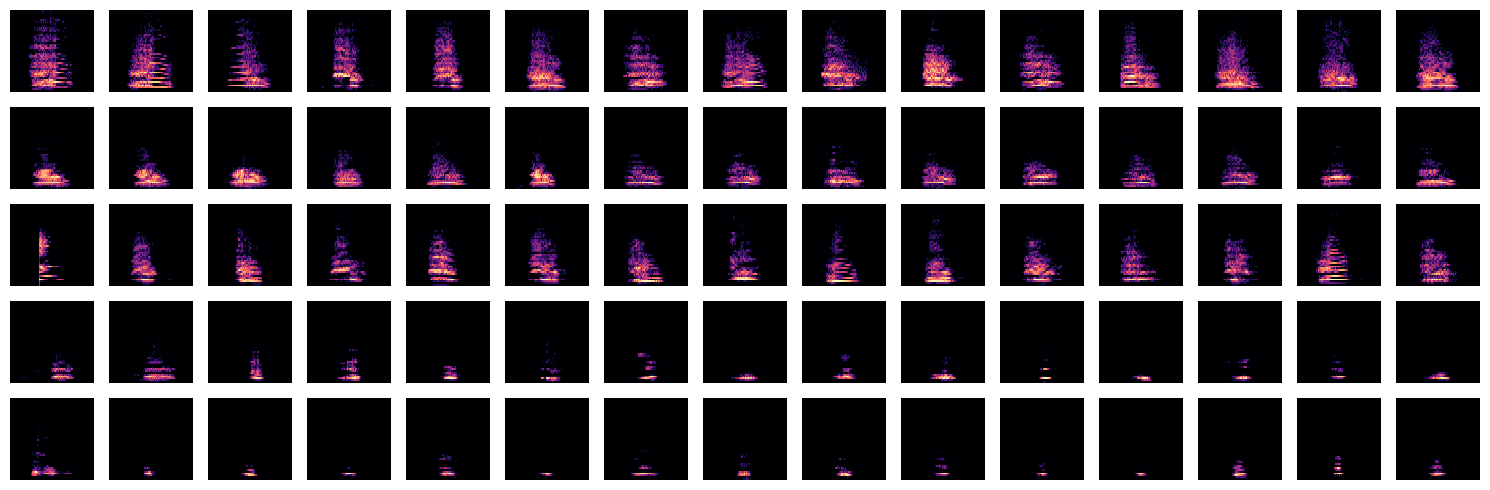

In [695]:
display_nearest_neighbours(nn_results_spec, calls_df)

In [ ]:
embeddings = umap.UMAP(precomputed_knn=nn_results_spec, n_neighbors=n_neighbors, n_components=2, min_dist=0.1).fit_transform(labels_and_spectrograms_scaled)

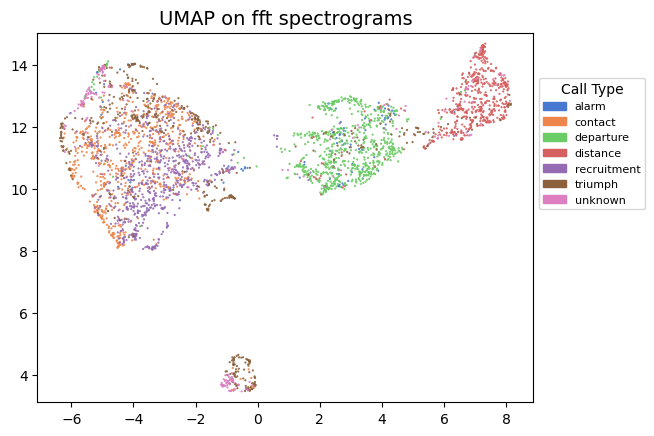

In [698]:
unique_call_types = labels_and_spectrograms_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_call_types))
call_type_to_color = {call_type: color for call_type, color in zip(unique_call_types, color_palette)}

# Assign colors to points
colors = [call_type_to_color[call_type] for call_type in labels_and_spectrograms_df["call_type"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
legend_patches = [Patch(color=color, label=call_type) for call_type, color in call_type_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)

plt.show()

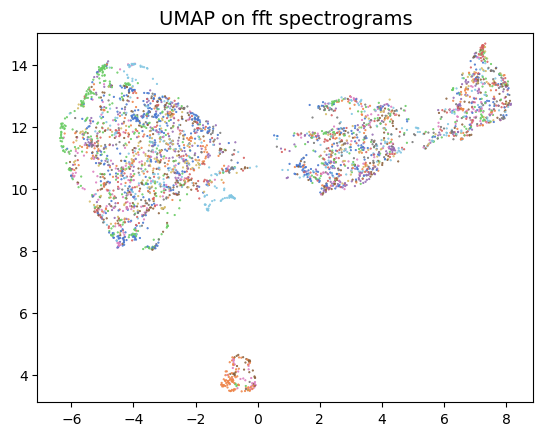

In [707]:
unique_track_ids = labels_and_spectrograms_df["track_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_track_ids))
track_id_to_color = {track_id: color for track_id, color in zip(unique_track_ids, color_palette)}

# Assign colors to points
colors = [track_id_to_color[track_id] for track_id in labels_and_spectrograms_df["track_ID"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# legend_patches = [Patch(color=color, label=track_id) for track_id, color in track_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Track_ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

GT00220 is clustered very clearly...

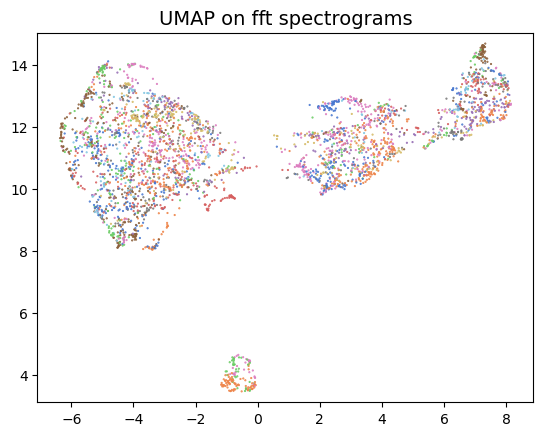

In [700]:
unique_goose_ids = labels_and_spectrograms_df["goose_ID"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {goose_id: color for goose_id, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[goose_id] for goose_id in labels_and_spectrograms_df["goose_ID"]]

# Scatter plot
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    c=colors,
    s=0.3
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP on fft spectrograms', fontsize=14)

# Legend
# legend_patches = [Patch(color=color, label=goose_id) for goose_id, color in goose_id_to_color.items()]
# plt.legend(
#     handles=legend_patches,
#     title="Goose ID",
#     fontsize=8,
#     title_fontsize=10,
#     loc="center left",
#     bbox_to_anchor=(1.0, 0.7)
# )

plt.show()

In [702]:
embeddings3d = umap.UMAP(precomputed_knn=nn_results_spec, n_neighbors=n_neighbors, n_components=3, min_dist=0.1).fit_transform(labels_and_spectrograms_scaled)

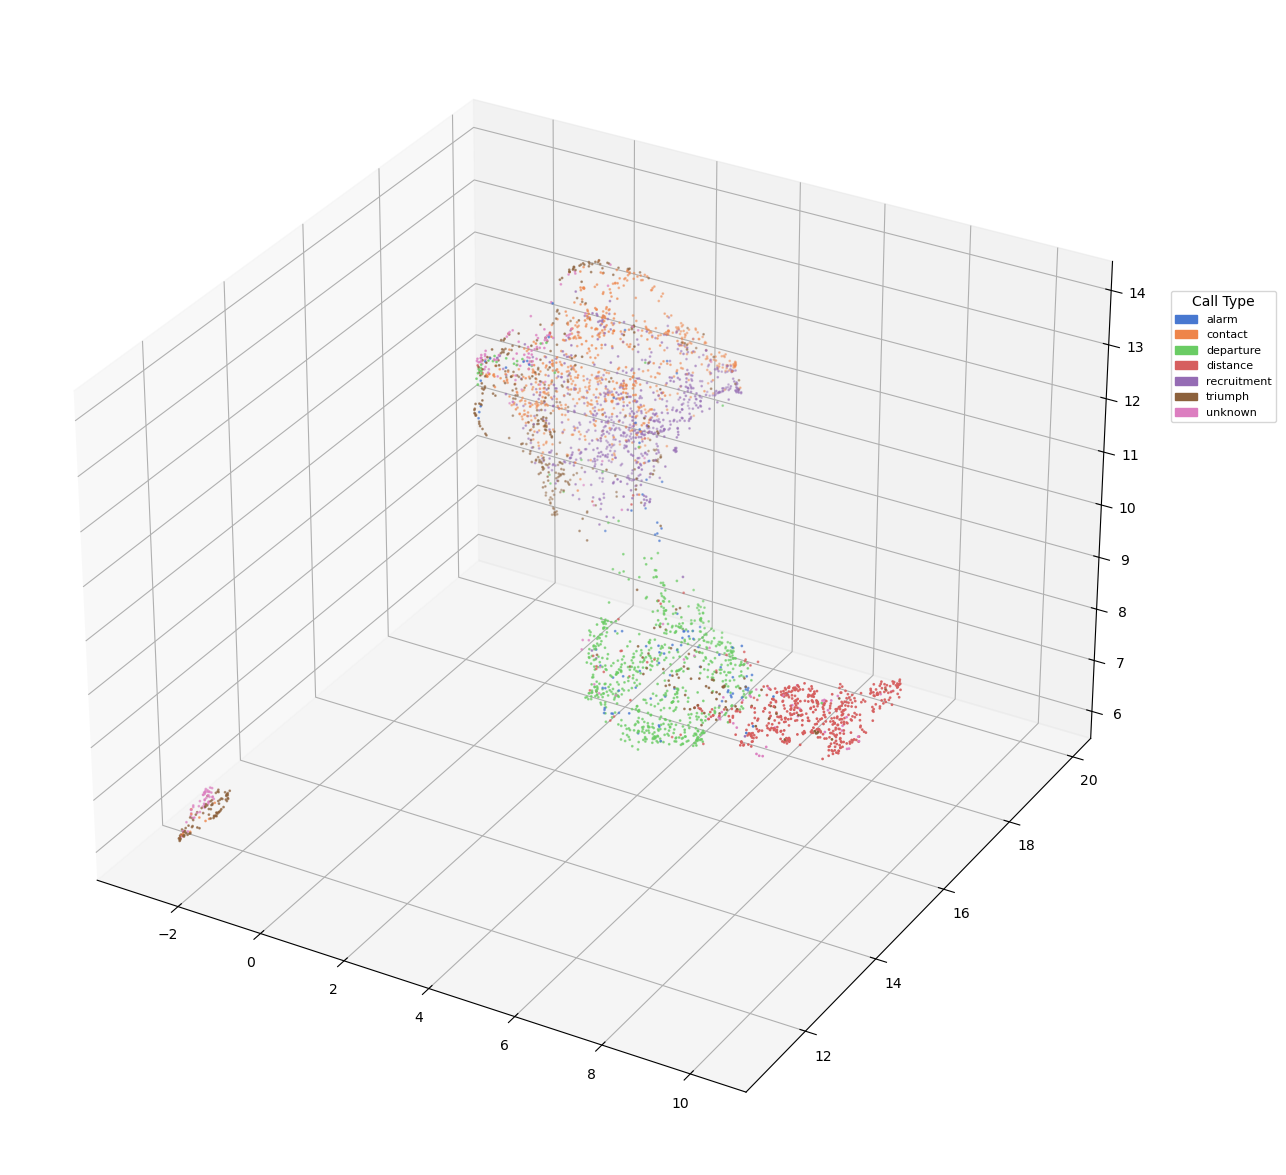

In [710]:
unique_goose_ids = labels_and_spectrograms_df["call_type"].unique()
color_palette = sns.color_palette("muted", len(unique_goose_ids))
goose_id_to_color = {call_type: color for call_type, color in zip(unique_goose_ids, color_palette)}

# Assign colors to points
colors = [goose_id_to_color[call_type] for call_type in labels_and_spectrograms_df["call_type"]]

# for 3D
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
ax.scatter( 
    embeddings3d[:, 0],  
    embeddings3d[:, 1],
    embeddings3d[:, 2],  
    c=colors,
    s=1)

legend_patches = [Patch(color=color, label=call_type) for call_type, color in goose_id_to_color.items()]
plt.legend(
    handles=legend_patches,
    title="Call Type",
    fontsize=8,
    title_fontsize=10,
    loc="center left",
    bbox_to_anchor=(1.0, 0.7)
)